In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from itertools import chain, combinations
from scipy import stats
from termcolor import colored
from sklearn.externals import joblib 
import datetime

In [41]:
from sklearn.cluster import KMeans

## Steps to Calculate New Cluster for tenant
1) (a) change file name (b) change tenant \
2) at very bottom, look at clustering results, highest avg. amount should be high value, next highest is high potential, lowest is low value

In [31]:
date_cols = ['HSTX_HSTDATE']
tx_hist = pd.read_csv('./cbnj/tx_hist.csv', delimiter='|', parse_dates=date_cols)
tenant = 'cbnj'

In [ ]:
tx_hist.head()

In [156]:
in_credit = ['BTR', 'CKS' 'CTP', 'CTR', 'FFR', 'FRS']
out_credit = ['DRC', 'DRW', 'DEP']
na_account = ['SVC']

In [157]:
def get_my_account(row):
    ''' 
        Obtain my_account from BUSCODE
    '''
    in_credit = ['BTR', 'CKS' 'CTP', 'CTR', 'FFR', 'FRS']
    out_credit = ['DRC', 'DRW', 'DEP']
    na_account = ['SVC']
    
    if row['HSTX_BUSCODE'] in out_credit:
        if row['HSTX_DIRECTION'] == 'I':
            return row['HSTX_DBTACCT']
        else:
            return row['HSTX_CDTACCT']
    elif row['HSTX_BUSCODE'] in in_credit:
        if row['HSTX_DIRECTION'] == 'I':
            return row['HSTX_CDTACCT']
        else:
            return row['HSTX_DBTACCT']
    elif row['HSTX_BUSCODE'] in na_account:
        return np.nan
    else:
        return np.nan
        

def reduce_bus_code(row): 
    ''' 
        Remap the BUSCODE as CT, DD, SVC, or N/A
    '''

    if row['HSTX_BUSCODE'] in ['BTR','CKS','CTP','CTR','FFR','FFS']: 
        return 'CT'
    elif row['HSTX_BUSCODE'] in ['DRC','DRW','DEP']: 
        return 'DD'
    elif row['HSTX_BUSCODE'] in ['SVC']: 
        return 'SVC'
    else: return 'N/A'
    
def get_quarter(row):
    return row['HSTX_HSTDATE'].quarter
        



In [158]:
tx_hist['HSTX_ACCT'] = np.nan
tx_hist['HSTX_ACCT'] = tx_hist.apply(get_my_account, axis=1)
# tx_hist['HSTX_BUSCODE'] = tx_hist.apply(reduce_bus_code, axis=1)

In [159]:
# tx_hist['HSTX_QUARTER'] =  tx_hist.apply(get_quarter, axis=1)

In [160]:
tx_hist_truncated = tx_hist.dropna(subset=['HSTX_ACCT'])
tx_hist_truncated = tx_hist_truncated[tx_hist_truncated['HSTX_MSGSTAT']=='PNRM']

In [161]:
tx_hist_truncated['HSTX_HSTDATE'].head()

0    2009-03-18
6    2009-03-18
10   2009-03-13
24   2009-03-18
36   2009-03-18
Name: HSTX_HSTDATE, dtype: datetime64[ns]

In [162]:
tx_hist_truncated['HSTX_HSTDATE'] = tx_hist_truncated['HSTX_HSTDATE'].astype(str)
tx_hist_truncated['HSTX_HSTYEAR'] = pd.DatetimeIndex(tx_hist_truncated['HSTX_HSTDATE']).year
#tx_hist_truncated['HSTX_HSTYEAR'] = tx_hist_truncated['HSTX_HSTDATE'].apply(lambda i: i.dt.year)

In [163]:
cols=['HSTX_HSTDATE', 'HSTX_ACCT', #'HSTX_AMOUNT', 'HSTX_DBT_AMOUNT', 'HSTX_CDT_AMOUNT', 'HSTX_TRANCODE', 'HSTX_SOURCE', 'HSTX_BUSCODE',
       'HSTX_FX_AMOUNT', 'HSTX_HSTYEAR']# , 'HSTX_QUARTER']

In [164]:
tx_hist_processed = tx_hist_truncated.loc[:, cols]

In [165]:
tx_hist_processed.columns

Index(['HSTX_HSTDATE', 'HSTX_ACCT', 'HSTX_FX_AMOUNT', 'HSTX_HSTYEAR'], dtype='object')

In [166]:
def get_credit_dummies(df):
    ct_dd_dummies = pd.get_dummies(df['HSTX_BUSCODE'], prefix='BUSCODE')
    df_concat = pd.concat([df, ct_dd_dummies], axis=1)
    df_concat = df_concat.drop(['HSTX_BUSCODE'], axis=1)
    return df_concat

def get_quarter_dummies(df):
    quarter_dummies = pd.get_dummies(df['HSTX_QUARTER'], prefix='QUARTER')
    df_concat = pd.concat([df, quarter_dummies], axis=1)
    df_concat = df_concat.drop(['HSTX_QUARTER'], axis=1)
    for i in range(4):
        df_concat['QUARTER_{}'.format(i+1)] = df_concat['QUARTER_{}'.format(i+1)] * df_concat['HSTX_FX_AMOUNT']
    return df_concat

In [167]:
# tx_hist_processed = get_quarter_dummies(tx_hist_processed)

In [ ]:
tx_hist_processed.head()

In [169]:
aggs = {
    'HSTX_HSTDATE': ['min', 'max'],
    'HSTX_ACCT': ['count'],
#     'HSTX_DBT_AMOUNT': ['mean', 'max', 'std'],
#     'HSTX_CDT_AMOUNT': ['mean', 'max', 'std'],
    'HSTX_FX_AMOUNT': ['sum', 'median'],
#     'BUSCODE_CT': ['sum'],
#     'BUSCODE_DD': ['sum']
}
# for i in range(4):
#     aggs['QUARTER_{}'.format(i+1)] = ['sum']

In [170]:
tx_agg = tx_hist_processed.groupby(['HSTX_ACCT','HSTX_HSTYEAR']).agg(aggs).reset_index(level=1)

In [171]:
# for col in tx_agg.columns:
#     print(col)
#     plt.hist(tx_agg[col], bins=50)
#     plt.show()

In [172]:
new_cols = ['Year', 'FirstTranDate', 'LastTranDate', 'NumTransactions', 'TotalYearlyAmount', 'MedianTransactionAmount']# , 'Q1_Amount', 'Q2_Amount', 'Q3_Amount', 'Q4_Amount']

tx_agg.columns = new_cols

In [ ]:
tx_agg.head(100)

In [174]:
def view_feature_histograms(df):
    numeric_cols = df.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        print(col)
        plt.hist(df[col], bins=20)
        plt.show()

def elbow_method(df):
    Sum_of_squared_distances = []
    K = range(2,15)
    kms = []
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(df)
        kms.append(km)
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return kms

def get_cluster_counts(kms, df):
    for km in kms:
        print('n_clusters: ', km.n_clusters)
        print(np.unique(km.predict(df), return_counts=True)[1])

def get_cluster_variances(kmeans, df_predict, df_raw):
    print('FEATURES WITH {} CLUSTERS'.format(kmeans.n_clusters))
    cluster_features = df_raw.loc[:]
    cluster_features['Cluster'] = kmeans.predict(df_predict)#*best_weights)
    for col in cluster_features.columns[:-1]:
        print(col)
        plt.scatter(cluster_features['Cluster'], cluster_features[col])
        plt.show()
    return cluster_features

def get_cluster_averages(kmeans, df_predict, df_raw):
    print('FEATURES WITH {} CLUSTERS'.format(kmeans.n_clusters))
    cluster_features = df_raw.loc[:]
    cluster_features['Cluster'] = kmeans.predict(df_predict)
    for col in cluster_features.columns[:-1]:
        print(col)
        averages = []
        cluster_sizes = []
        for cluster in range(kmeans.n_clusters):
            features = cluster_features.loc[cluster_features['Cluster'] == cluster, col]
            averages.append(np.mean(features))
            cluster_sizes.append(features.shape[0])
        plt.bar(np.arange(kmeans.n_clusters), averages)
        print(averages)
        plt.show()
    return cluster_features

def get_months_diff(series1, series2):
    return 12 * (series1.dt.year - series2.dt.year) + (series1.dt.month + 1 - series2.dt.month)

def log2p(x):
    return np.log1p(x+2)

### Try aggregates over all years per account

In [175]:
# yearly_aggs = {column: ['mean'] for column in tx_agg.columns}
# yearly_aggs['FirstTranDate'] = ['min']
# yearly_aggs['LastTranDate'] = ['max']
# # for col in ['NumTransactions', 'TotalYearlyAmount']:
# #     yearly_aggs[col].append(('std', lambda s: s.std(ddof=0)))
# del yearly_aggs['Year']
# yearly_aggs['NumTransactions'].append('sum')
# yearly_aggs

yearly_aggs = {'NumTransactions': ['mean', 'sum'],
              'TotalYearlyAmount': ['mean'],
              'MedianTransactionAmount': ['median']}

In [176]:
tx_agg_yearly = tx_agg.groupby(level=0).agg(yearly_aggs, ddof=1)
tx_agg_yearly.columns = ['{}_{}'.format(col[0], col[1]) for col in tx_agg_yearly.columns]
tx_agg_yearly = tx_agg_yearly.fillna(0)

In [177]:
# tx_agg_yearly['Today'] = pd.Timestamp.now()
# tx_agg_yearly['AccountLife'] = get_months_diff(tx_agg_yearly['Today'],
#                                                tx_agg_yearly['FirstTranDate_min'])
# tx_agg_yearly['MonthsActivity'] = get_months_diff(tx_agg_yearly['LastTranDate_max'],
#                                                   tx_agg_yearly['FirstTranDate_min'])
# tx_agg_yearly['MonthsInactivity'] = tx_agg_yearly['AccountLife'] - tx_agg_yearly['MonthsActivity']
# tx_agg_yearly['Years_Activity'] =(tx_agg_yearly['MonthsActivity']//12)+1

In [ ]:
tx_agg_yearly.head()

In [179]:
# tx_agg_yearly = tx_agg_yearly[
#     ['NumTransactions_sum',
#      'NumTransactions_mean', 'TotalYearlyAmount_mean', #'MedianTransactionAmount_mean', #'TotalYearlyAmount_std',
#      'Q1_Amount_mean', 'Q2_Amount_mean', 'Q3_Amount_mean', 'Q4_Amount_mean',
# #      'AccountLife', 'MonthsActivity', 'MonthsInactivity', 'Years_Activity'
#                               ]]

In [180]:
def filter_min_transactions(df, min_transactions):
    return df.loc[df['NumTransactions_sum'] >= min_transactions ].drop('NumTransactions_sum', axis=1)

In [181]:
df_raw = tx_agg_yearly.select_dtypes(include=np.number)
df_raw = filter_min_transactions(df_raw, 1)
df_predict = df_raw.applymap(np.log1p)

NumTransactions_mean


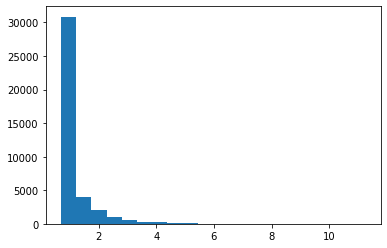

TotalYearlyAmount_mean


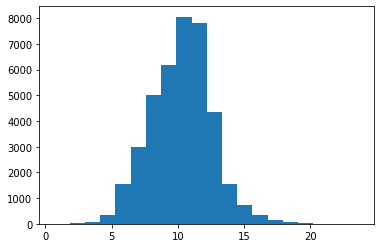

MedianTransactionAmount_median


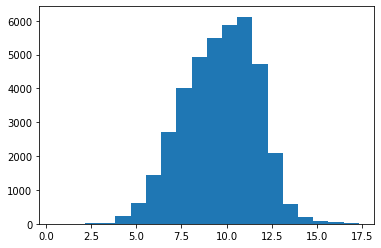

In [182]:
view_feature_histograms(df_predict)

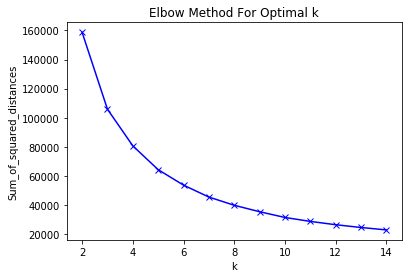

In [183]:
kms = elbow_method(df_predict)

In [184]:
km_best = kms[1]

FEATURES WITH 3 CLUSTERS
NumTransactions_mean


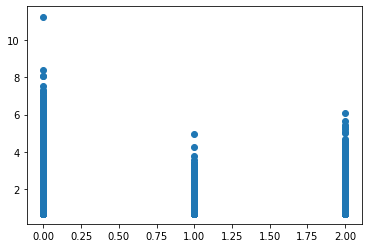

TotalYearlyAmount_mean


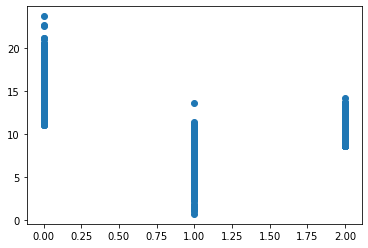

MedianTransactionAmount_median


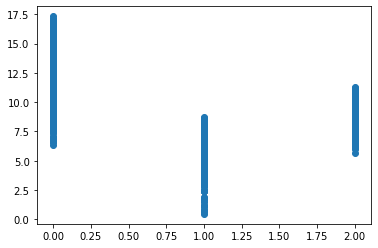

In [185]:
cluster_feats = get_cluster_variances(km_best, df_predict, df_predict)

FEATURES WITH 3 CLUSTERS
NumTransactions_mean
[15.911683919920073, 1.583901830542304, 2.4812952603291945]


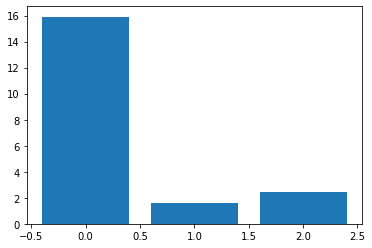

TotalYearlyAmount_mean
[5446244.315226882, 2843.564476209572, 39421.364909673925]


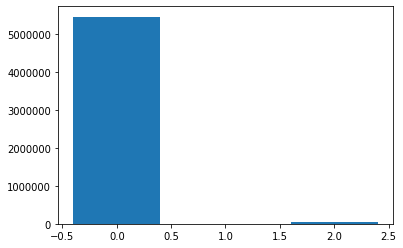

MedianTransactionAmount_median
[259321.36498069557, 1835.108381385063, 20807.022966676832]


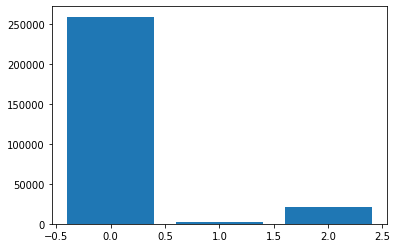

In [186]:
feats = get_cluster_averages(km_best, df_predict, df_raw)

## CHANGE THESE BEFORE RUNNING (look at above graphs)

In [187]:
cluster_names = {
        0: 'High Value',
        2: 'High Potential',
        1: 'Low Value'
    }

In [188]:
feats['Cluster_Name'] = feats['Cluster'].map(lambda x: cluster_names[x])

In [39]:
feats[['Cluster', 'Cluster_Name']].to_csv('{}_clusters.csv'.format(tenant), header=True)

In [260]:
final = feats[['Cluster', 'Cluster_Name']].reset_index()

In [261]:
final.head()

,HSTX_ACCT,Cluster,Cluster_Name
0,0001930EE41A36676F6048A800D9895D91B7CCD9C031D5...,2,Low Value
1,0013AE00DEA021367EDB4D39CB0AEA34A6C427B934DB62...,2,Low Value
2,001992E50A4420C3F91D3021204CA55E93D73D36BD8B60...,2,Low Value
3,00212D278A461910DBE0965A3AC2ADDCEAA13533A00460...,1,High Value
4,0023AB612D70BA2201392DA8B3006DA7C3BDAD613A69A6...,2,Low Value


In [189]:
joblib.dump(km_best, '{}_clustering.pkl'.format(tenant)) 

['legacy_clustering.pkl']

In [262]:
# choose clusters names/labels
#this is if we make a separate file, so let's not do this for now
# data = [[0, 'High Value'],
#         [2, 'High Potential'],
#         [1, 'Low Value']]
# cluster_names = pd.DataFrame(data, columns=['Cluster', 'Cluster_Name']).set_index('Cluster')
final.to_csv('{}_cluster_names.csv'.format(tenant), header=True, index = False)